In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from statsmodels.tsa.api import VAR
from tqdm import tqdm
from dotenv import load_dotenv
os.chdir("..")

load_dotenv("globs.env")
tickers   = os.getenv("TICKERS").split(",")
media_dir = os.getenv("MEDIA_DIR")
data_dir  = os.getenv("DATA_DIR")

In [2]:
## Load data
df = pd.read_csv(data_dir + "/returns.csv").set_index("date").ffill() # handle NaN
df = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")
X = (df - df.mean()) / df.std(ddof=0)
n, p = X.shape
print(f"n x p:", (n, p))

n x p: (1222, 15)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


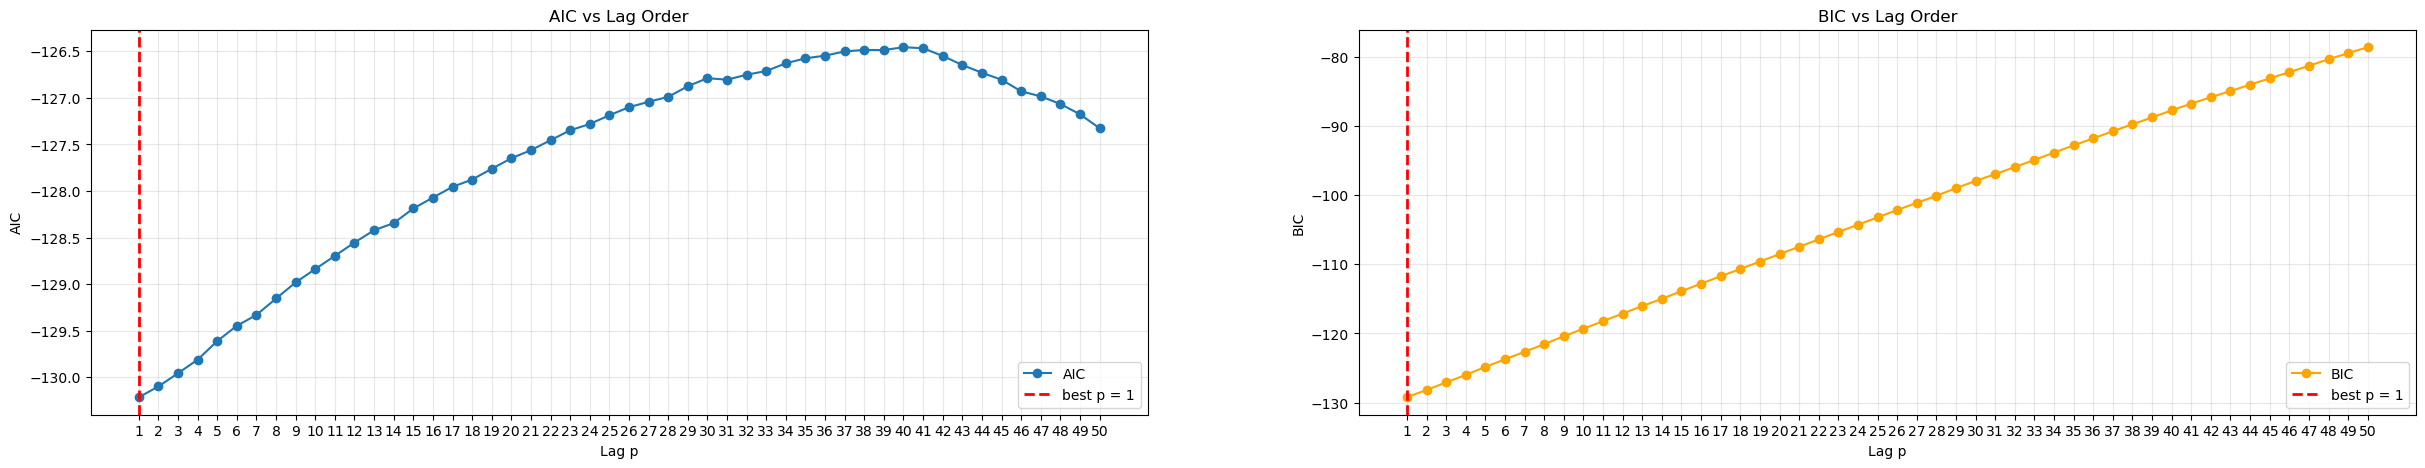

In [3]:
# VAR order selection (hyperparameter tuning)

maxlags = 50
model = VAR(df)

aic_values = {}
bic_values = {}

for p in range(1, maxlags + 1):
    res = model.fit(p)
    aic_values[p] = res.aic
    bic_values[p] = res.bic

lags = list(aic_values.keys())
aics = list(aic_values.values())
bics = list(bic_values.values())

best_p_aic = min(aic_values, key=aic_values.get)
best_p_bic = min(bic_values, key=bic_values.get)

fig, ax = plt.subplots(1, 2, figsize=(30,5))

# AIC plot
ax[0].plot(lags, aics, marker='o', label='AIC')
ax[0].axvline(best_p_aic, color='red', linestyle='--', linewidth=2,
              label=f"best p = {best_p_aic}")
ax[0].set_title("AIC vs Lag Order")
ax[0].set_xlabel("Lag p")
ax[0].set_ylabel("AIC")
ax[0].set_xticks(lags)
ax[0].grid(alpha=0.3)
ax[0].legend(loc="lower right")

# BIC plot
ax[1].plot(lags, bics, marker='o', color='orange', label='BIC')
ax[1].axvline(best_p_bic, color='red', linestyle='--', linewidth=2,
              label=f"best p = {best_p_bic}")
ax[1].set_title("BIC vs Lag Order")
ax[1].set_xlabel("Lag p")
ax[1].set_ylabel("BIC")
ax[1].set_xticks(lags)
ax[1].grid(alpha=0.3)
ax[1].legend(loc="lower right")

plt.savefig(media_dir + "/AIC_BIC_plot.png")
plt.show()

In [4]:
p = 1 # minimizes AIC & BIC
var1 = model.fit(p)
print(var1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Nov, 2025
Time:                     16:37:40
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                   -129.210
Nobs:                     1221.00    HQIC:                  -129.836
Log likelihood:           53747.6    FPE:                2.81146e-57
AIC:                     -130.214    Det(Omega_mle):     2.31271e-57
--------------------------------------------------------------------
Results for equation AAPL
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000681         0.000508            1.341           0.180
L1.AAPL          0.033567         0.041388            0.811           0.417
L1.MSFT          0.027289         0.052298            0.522           0.602
L1.GO

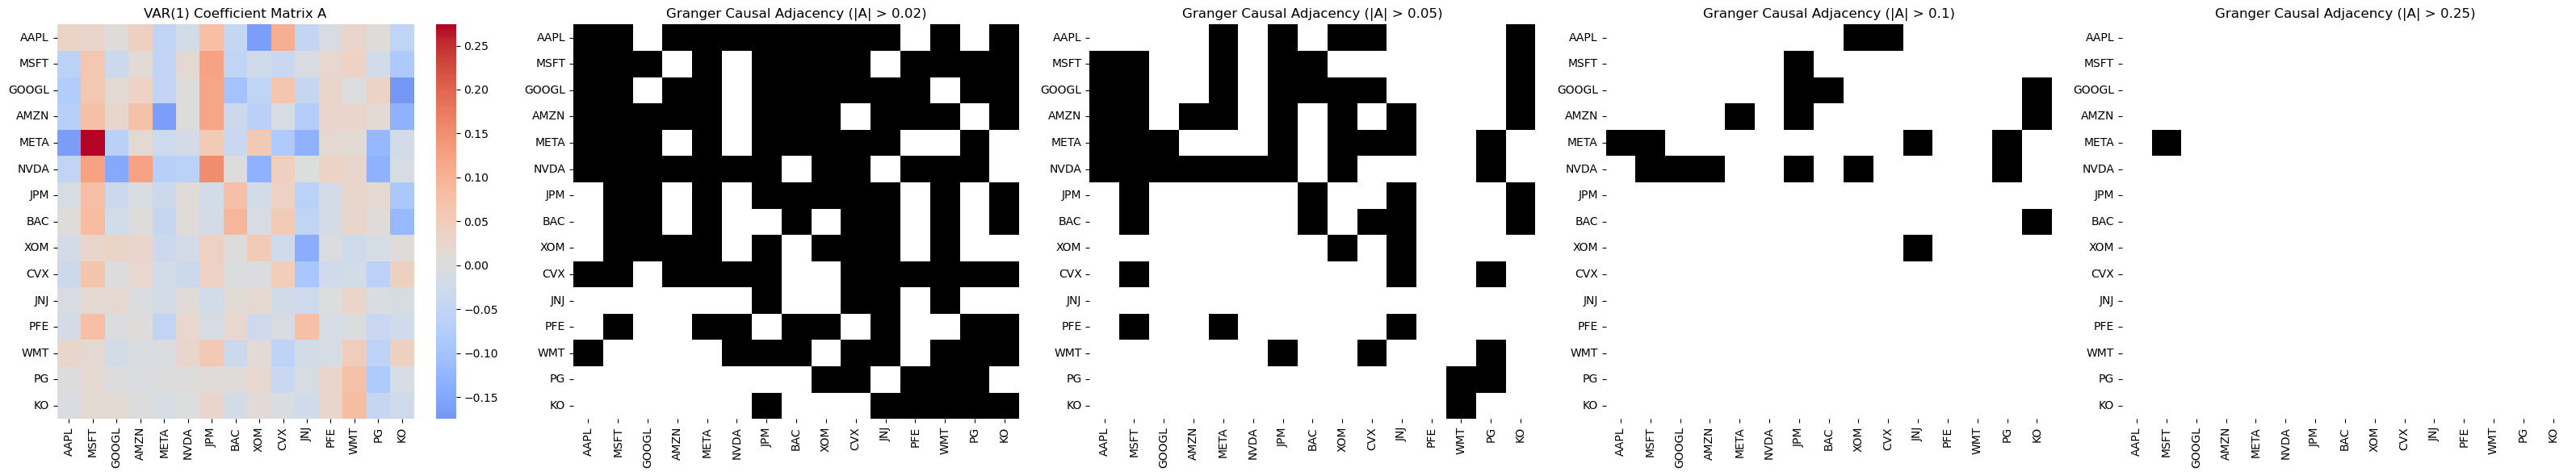

In [5]:
A = var1.coefs[0]
A_df = pd.DataFrame(A, index=df.columns, columns=df.columns)

threshold_list = [0.02, 0.05, 0.10, 0.25]
m = len(threshold_list)
fig, ax = plt.subplots(1, 1 + m, figsize=(8*m,6))

# Heatmap 1: VAR Coefficient Matrix
sns.heatmap(A_df, cmap="coolwarm", center=0, ax=ax[0])
ax[0].set_title("VAR(1) Coefficient Matrix A")

# Heatmap 2: Thresholded Adjacency
for i, threshold in enumerate(threshold_list):
    adj = (A_df.abs() > threshold).astype(int)
    sns.heatmap(adj, cmap="Greys", cbar=False, ax=ax[i+1])
    ax[i+1].set_title(f"Granger Causal Adjacency (|A| > {threshold})")

plt.tight_layout()
plt.savefig(media_dir + "/VAR_and_adj_grid.png")
plt.show()

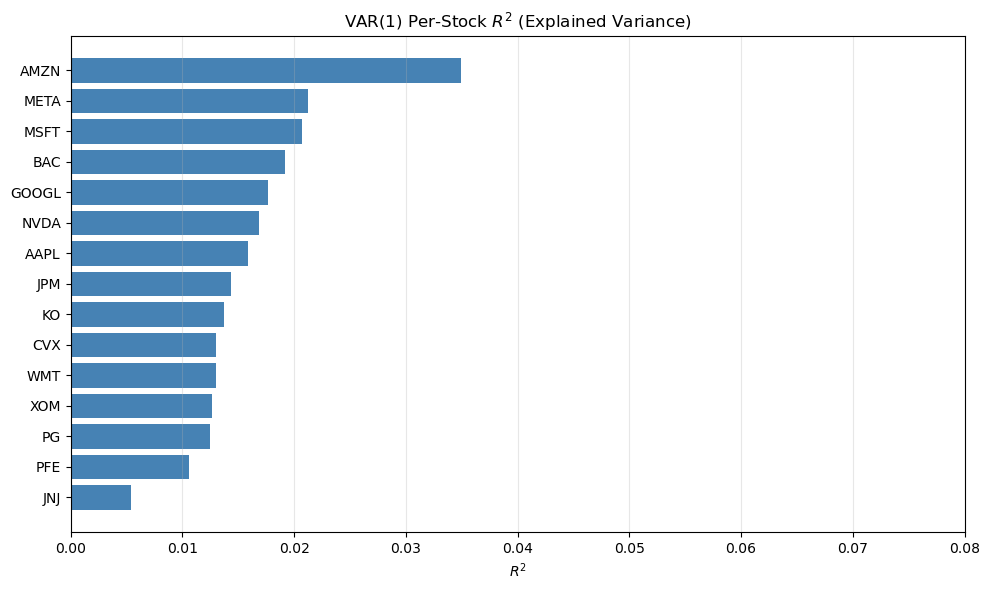

In [6]:
resid = var1.resid
data_aligned = df.loc[resid.index]
r2 = 1 - resid.var() / data_aligned.var()
r2_sorted = r2.sort_values(ascending=True)

plt.figure(figsize=(10,6))
plt.barh(r2_sorted.index, r2_sorted.values, color="steelblue")
plt.xlabel(r"$R^2$")
plt.title(r"VAR(1) Per-Stock $R^2$ (Explained Variance)")
plt.xlim(0, 0.08)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(media_dir + "/VAR_r2_barplot.png")
plt.show()